# Human Activity Recognition with Smartphones

This notebook descirbes experiments on [UCI-HAR](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones) dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(42)

In [3]:
TEST_DATA = 'test.csv'
TRAIN_DATA = 'train.csv'

In [4]:
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)
train_df.shape, test_df.shape

((7352, 563), (2947, 563))

Current train:test ratio = 70:30. Further split test set to dev and test set with final train:dev:test ratio = 70:15:15.

Dev set will be used for hyper-parameter tuning. Test set will only be used after the training and hyper-parameter tuning phases are finished to have a fair evaluation of the model

In [5]:
# print(*(f'{c}\n' for c in train_df.columns))

In [6]:
train_df['subject'].unique()

array([ 1,  3,  5,  6,  7,  8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26,
       27, 28, 29, 30])

In [7]:
train_df['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

<AxesSubplot:>

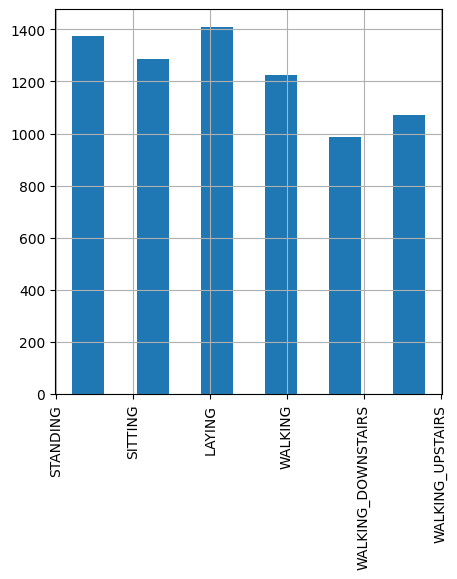

In [8]:
train_df['Activity'].hist(xrot=90, bins=6, figsize=(5,5), rwidth=0.5)

In [9]:
# remove laying and walking data to have 4-class multinomial classification
train_df = train_df[~train_df['Activity'].isin(['STANDING', 'WALKING'])]
test_df = test_df[~test_df['Activity'].isin(['STANDING', 'WALKING'])]

train_df.shape

(4752, 563)

<AxesSubplot:>

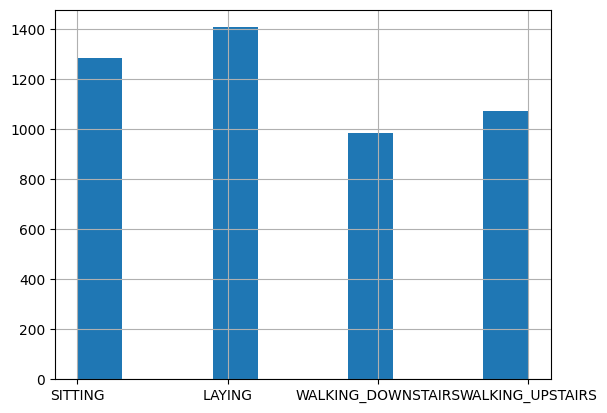

In [10]:
train_df['Activity'].hist()

In [11]:
# select meaningful time-domain features for training
features = [
    'tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X',
    'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y',
    'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-min()-Z',
    
    'tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-mean()-Z', 'tBodyGyro-std()-X',
    'tBodyGyro-std()-Y', 'tBodyGyro-std()-Z', 'tBodyGyro-max()-X', 'tBodyGyro-max()-Y',
    'tBodyGyro-max()-Z', 'tBodyGyro-min()-X', 'tBodyGyro-min()-Y', 'tBodyGyro-min()-Z',
    
    'tGravityAcc-std()-X', 'tGravityAcc-std()-Y', 'tGravityAcc-std()-Z', 'tGravityAcc-mad()-X',
    'tGravityAcc-mad()-Y', 'tGravityAcc-mad()-Z', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y',
    'tGravityAcc-max()-Z', 'tGravityAcc-min()-X', 'tGravityAcc-min()-Y', 'tGravityAcc-min()-Z',
    
    'Activity'
]

train_df = train_df[[f for f in features]]
test_df = test_df[[f for f in features]]
train_df.shape

(4752, 37)

In [12]:
X_train = train_df.iloc[:, :-1]
y_train = train_df[['Activity']]

X_test_dev = test_df.iloc[:, :-1]
y_test_dev = test_df[['Activity']]

In [13]:
le = preprocessing.LabelEncoder()
le.fit(y_train['Activity'].unique().tolist())

LabelEncoder()

In [14]:
# encode train and test set labels
y_train = le.transform(y_train)
y_test_dev = le.transform(y_test_dev)

/Users/nguyenvanbinh/Desktop/hardware-ai/venv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
y_train

array([1, 1, 1, ..., 3, 3, 3])

In [16]:
# split test set by half to form dev and test set
X_dev, X_test, y_dev, y_test = train_test_split(
    X_test_dev, y_test_dev, train_size=0.5, random_state=42, shuffle=True
)

## Pytorch model

Build an MLP using Pytorch. Experiment with random hyper-parameter to have an estimation of model performance

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [18]:
# try with random hidden_size and num_epochs
input_size = 36
hidden_size = 15
num_classes = 4
num_epochs = 7
batch_size = 64
learning_rate = 0.1
device = torch.device('cpu')

In [19]:
class HarDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return torch.Tensor(self.X.iloc[index].astype(float)), self.y[index]
    
    def __len__(self):
        return len(self.X)

In [20]:
train_dataset = HarDataset(X_train, y_train)
dev_dataset = HarDataset(X_dev, y_dev)
test_dataset = HarDataset(X_test, y_test)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)
dev_loader = DataLoader(
    dataset=dev_dataset, 
    batch_size=batch_size, 
    shuffle=False   
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [21]:
class FCN(nn.Module):
    '''
    Fully connected network (MLP) with one hidden layer using ReLU activation function
    '''
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCN, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out) 
        return out

In [22]:
model = FCN(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

def test_conf_matrix(benchmark_loader, is_test_set=False):
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for data, labels in benchmark_loader:
            labels = labels.to(device)
            y_true.extend(labels)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_samples
        if is_test_set:
            print(f'Accuracy on test set: {acc:.4f}%')
        else:
            print(f'Accuracy on dev set: {acc:.4f}%')
        
        cf_mat = confusion_matrix(y_true, y_pred)
        cm_df = pd.DataFrame(cf_mat, index=[i for i in range(num_classes)], columns=[i for i in range(num_classes)])
        plt.figure(figsize=(4,3))
        sb.heatmap(cm_df, annot=True)

Before training
Accuracy on dev set: 10.8446%


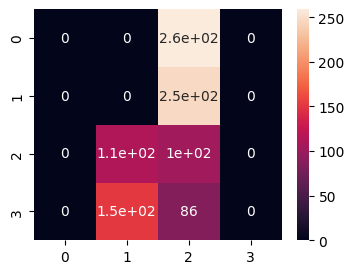

In [24]:
print('Before training')
test_conf_matrix(dev_loader)

In [25]:
n_total_steps = len(train_loader)
n_total_steps

75

In [26]:
losses = [] # to record loss over training time

for epoch in range(num_epochs):
    for i, (data, label) in enumerate(train_loader):
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    scheduler.step()

    if epoch % 2 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}: loss = {loss.item():.4f}', end='; ')
        print(f"learning rate = {optimizer.param_groups[0]['lr']}")

Epoch 1/7: loss = 0.3584; learning rate = 0.1
Epoch 3/7: loss = 0.0178; learning rate = 0.05
Epoch 5/7: loss = 0.0199; learning rate = 0.025
Epoch 7/7: loss = 0.0006; learning rate = 0.0125


After training
Accuracy on dev set: 94.6820%


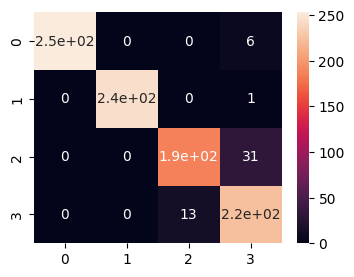

In [27]:
print('After training')
test_conf_matrix(dev_loader)

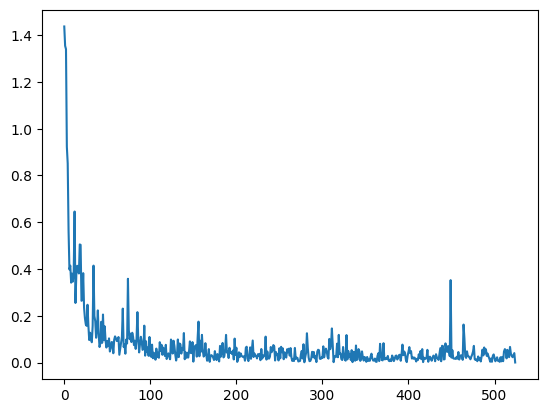

In [28]:
plt.plot(losses)

## Hyper-parameter tuning using RayTune

In [29]:
from ray import tune 

In [30]:
def train(model, optimizer, train_loader, epochs):
    model.train()
    for epoch in range(epochs):
        for i, (data, label) in enumerate(train_loader):
            label = label.to(device)
            output = model(data)
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

In [31]:
def test(model, benchmark_loader):
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for data, labels in benchmark_loader:
            labels = labels.to(device)
            y_true.extend(labels)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_samples
        return acc

In [36]:
def train_fcn(config):
    model = FCN(input_size=36, hidden_size=config['hidden'], num_classes=4)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    epochs = config['epochs']
    for i in range(2):
        train(model, optimizer, train_loader, epochs=5)
        acc = test(model, dev_loader)
        tune.report(mean_accuracy=acc)

# run grid_search with different values of learning rate, number of hidden neurons and number of epochs
analysis = tune.run(
    train_fcn, 
    config={
        "lr": tune.grid_search([0.001, 0.01, 0.1]),
        'hidden': tune.grid_search(list(range(5,40,5))),
        'epochs': tune.grid_search(list(range(5,10,1)))
    }, 
    verbose=1
)

2022-09-13 11:56:34,015	INFO tune.py:758 -- Total run time: 435.91 seconds (435.61 seconds for the tuning loop).


In [37]:
df = analysis.dataframe()
df.head(3)

,mean_accuracy,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,...,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,config/epochs,config/hidden,config/lr,logdir
0,90.198123,7.718296,False,NaN,NaN,2,0b156_00000,2cef81bb01c6462e944ed02bd263da2d,2022-09-13_11-49-37,1663040977,...,Van-Binhs-Mac.local,127.0.0.1,15.165091,0,2,0.002672,5,5,0.001,/Users/nguyenvanbinh/ray_results/train_fcn_202...
1,87.799791,7.968555,False,NaN,NaN,2,0b156_00001,823b512ce05a485cb9aa1e9f995c4fc0,2022-09-13_11-49-40,1663040980,...,Van-Binhs-Mac.local,127.0.0.1,15.367696,0,2,0.003856,6,5,0.001,/Users/nguyenvanbinh/ray_results/train_fcn_202...
2,91.866528,8.050273,False,NaN,NaN,2,0b156_00002,c60808d5f74c49b4bcafc0e6721b115b,2022-09-13_11-49-41,1663040981,...,Van-Binhs-Mac.local,127.0.0.1,15.592065,0,2,0.003550,7,5,0.001,/Users/nguyenvanbinh/ray_results/train_fcn_202...


In [38]:
best_result = analysis.get_best_trial(metric="mean_accuracy", mode='max').last_result  # Get best trial's last results
best_result['mean_accuracy'], best_result['config']

(95.93326381647549, {'lr': 0.01, 'hidden': 25, 'epochs': 6})

In [ ]:
assert False

## Re-train with selected hyper-params

In [40]:
model = FCN(input_size=36, hidden_size=25, num_classes=4).to(device)
num_epochs = 6
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

losses = []

for epoch in range(num_epochs):
    for i, (data, label) in enumerate(train_loader):
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    scheduler.step()

    if epoch % 2 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}: loss = {loss.item():.4f}', end='; ')
        print(f"learning rate = {optimizer.param_groups[0]['lr']}")

Epoch 1/6: loss = 0.0490; learning rate = 0.01
Epoch 3/6: loss = 0.0225; learning rate = 0.005
Epoch 5/6: loss = 0.0689; learning rate = 0.0025


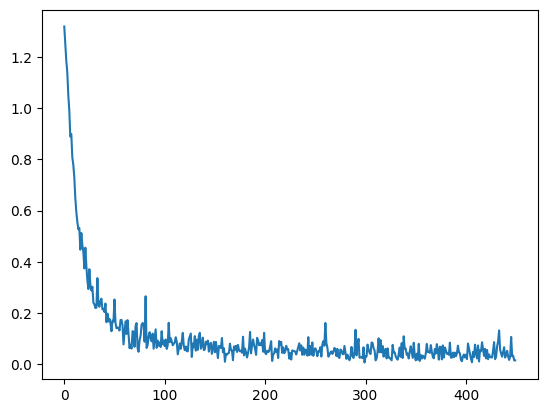

In [41]:
plt.plot(losses)

After training
Accuracy on dev set: 95.7247%


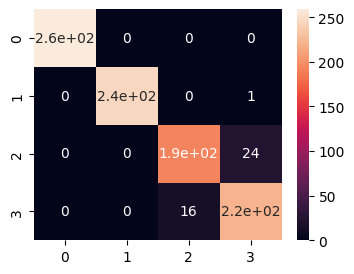

In [42]:
print('After training')
test_conf_matrix(dev_loader)

Accuracy on test set: 94.5833%


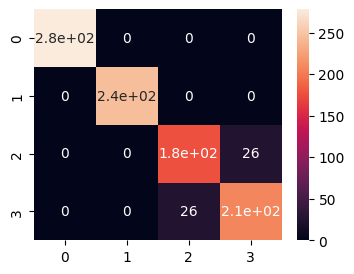

In [43]:
test_conf_matrix(test_loader, True)

In [44]:
torch.save(model, 'model_finetune.pth')